In [5]:
import pandas as pd
import matplotlib as plt
import yfinance as yf

plt.rcParams['figure.figsize'] = [10, 10]



In [6]:
def exp_smooth(series, alpha):
    smoothed_value = series[0]
    results = []
    for value in series:
        smoothed_value = (1 - alpha) * smoothed_value + alpha * value
        results.append(smoothed_value)
    return results


tesla_ticker = yf.Ticker('TSLA')
tesla_frame = tesla_ticker.history(start="2020-10-01", end="2021-10-30")['Close'].to_frame()

tesla_frame_decomposed = tesla_frame

# get smoothed trend
tesla_frame_decomposed ['Trend'] = exp_smooth(tesla_frame['Close'], .05)

# get residual from the difference between observed and trend
tesla_frame_decomposed['Residue'] = tesla_frame_decomposed['Close'] - tesla_frame_decomposed['Trend']

# get residual differences - hopefully more stationary than residuals on own
tesla_frame_decomposed['Res_diff'] = tesla_frame_decomposed['Residue'] - tesla_frame_decomposed['Residue'].shift()


<AxesSubplot:xlabel='Date'>

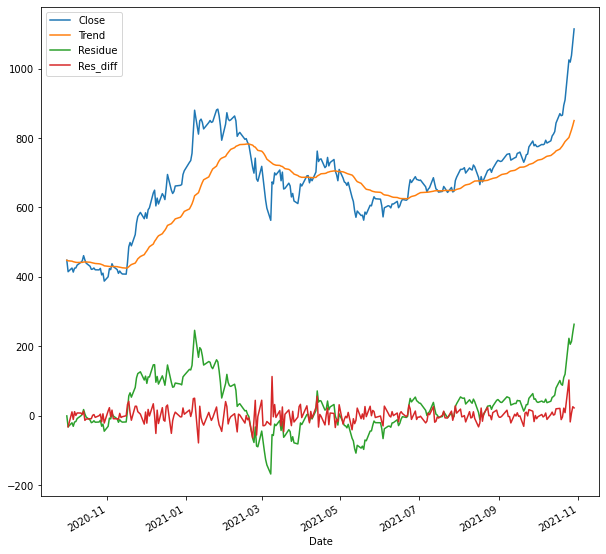

In [7]:
tesla_frame_decomposed.head()
tesla_frame_decomposed.plot()

<AxesSubplot:xlabel='Date'>

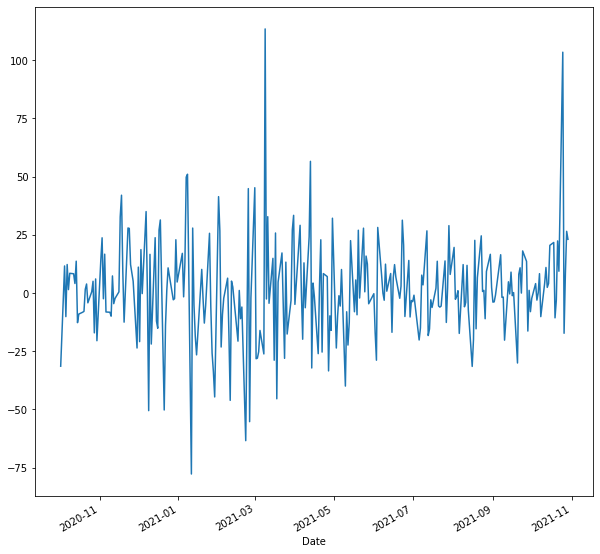

In [8]:
tesla_frame_decomposed['Res_diff'].plot()

## Use AR(p) to predict the residuals

In [9]:
import numpy as np

def train_ar(values, order):
    target_vector = np.array(values[order:])
    lagged_values = []
    for i in range(len(values) - order):
        lagged_values.append(values[i:i+order])
        design_matrix = np.array(lagged_values)
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector

In [10]:
tesla_resid_diff_arcoeffs = train_ar(tesla_frame_decomposed['Res_diff'], 12)

tesla_resid_diff_arcoeffs





array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

#### need to drop the Nan values

In [11]:

tesla_frame_decomposed = tesla_frame_decomposed.dropna()

In [12]:
tesla_resid_diff_arcoefs = train_ar(tesla_frame_decomposed['Res_diff'],12)
tesla_resid_diff_arcoefs

array([-0.02240184, -0.13063035, -0.02361876,  0.11036429,  0.10018347,
       -0.00230742,  0.07896713, -0.04172463,  0.04714342,  0.05247898,
       -0.04395471, -0.10465242])

#### use ar coeffs to get predicted values


In [14]:
import math

def predict(coeffs, data):
    predicted_values = [math.nan] * len(coeffs) # we cannot predict the first few values
    for i in range(len(coeffs), len(data)):
        predicted_values.append(np.dot(coeffs, data[i-len(coeffs):i]))
    return np.array(predicted_values)


In [15]:
# get predicted differences in residual
tesla_residue_diff_prediction = predict (tesla_resid_diff_arcoefs, tesla_frame_decomposed['Res_diff'])

# convert predicted differences to predicted values
tesla_residue_prediction = tesla_residue_diff_prediction + tesla_frame_decomposed['Residue'].shift()

### Use Naive differences to predict the trend

In [17]:
# get differences from trend
tesla_trend_differences = (tesla_frame_decomposed['Trend'].shift(1)- tesla_frame_decomposed['Trend'].shift(2))

# get naive predictions for trend using shift - take the last trend value differences and add to last value
tesla_trend_prediction = tesla_frame_decomposed['Trend'].shift(1) + tesla_trend_differences

### Get overall prediction by combining predicted trend and predicted residual


In [20]:
tesla_frame_decomposed['Prediction'] = tesla_trend_prediction + tesla_residue_prediction

tesla_frame_decomposed.tail(10)


C:\Users\hugho\AppData\Local\Temp\ipykernel_6928\3414464417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_frame_decomposed['Prediction'] = tesla_trend_prediction + tesla_residue_prediction


,Close,Trend,Residue,Res_diff,Prediction
Date,,,,,
2021-10-18,870.109985,768.110210,101.999776,21.711547,844.637132
2021-10-19,864.270020,772.918200,91.351819,-10.647956,872.968162
2021-10-20,865.799988,777.562290,88.237698,-3.114121,871.470183
2021-10-21,894.000000,783.384175,110.615825,22.378127,872.507988
2021-10-22,909.679993,789.698966,119.981027,9.365202,898.260712
2021-10-25,1024.859985,801.457017,223.402968,103.421942,916.558813
2021-10-26,1018.429993,812.305666,206.124327,-17.278641,1028.615952
2021-10-27,1037.859985,823.583382,214.276604,8.152277,1028.244622
2021-10-28,1077.040039,836.256215,240.783824,26.507221,1057.534139


<AxesSubplot:xlabel='Date'>

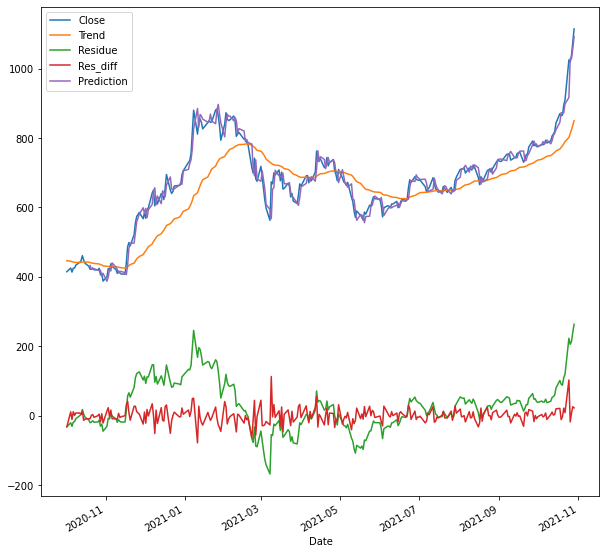

In [21]:
tesla_frame_decomposed.plot()

In [31]:
def rmse(predicted, actual):
    diffs = predicted - actual
    return math.sqrt((diffs ** 2).sum()) / len(diffs.dropna())

In [32]:
rmse(predicted, tesla_frame['Close'])

1.3892582244983507